In [1]:
import sys
from os.path import join,expanduser
user_home_dir = expanduser('~')

#point to the correct src path if this doesnt work
sys.path.insert(0,join(user_home_dir,'efs_ecco/ameza/ESS25-Team_SHERLOCCS/src'))

from src import * 

from dask.distributed import Client

In [2]:
#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:42701")
# client = Client()
client.ncores
client.restart()
client

OSError: Timed out trying to connect to tcp://127.0.0.1:42701 after 30 s

In [2]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join('/efs_ecco','ameza')

# for access_mode = 's3_open_fsspec', need to specify the root directory 
# containing the jsons
jsons_root_dir = join('/efs_ecco','mzz-jsons')

access_mode = 's3_open_fsspec'

## access datasets needed for this tutorial

ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4", \
                   "ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4"]
StartDate = '1991-01'
EndDate = '2018-12'
ds_dict = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                            StartDate=StartDate,EndDate=EndDate,\
                                            mode=access_mode,\
                                            download_root_dir=ECCO_dir,\
                                            max_avail_frac=0.5,\
                                            jsons_root_dir=jsons_root_dir)

In [3]:
ds_GEOM = ds_dict[ShortNames_list[0]]

In [4]:
def read_bin(file_directory, file_name, ds_GEOM): 
    geoflx = ecco.read_llc_to_tiles(file_directory, file_name)
    # Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
    geoflx_llc = xr.DataArray(geoflx,coords={'tile': ds_GEOM.tile.values,
                                             'j': ds_GEOM.j.values,
                                             'i': ds_GEOM.i.values},dims=['tile','j','i'])
    return geoflx_llc

In [5]:
ywu_surf_mask = xr.open_dataset("/efs_ecco/ywu/mask3d_ccc_surface.nc")["mask_ccc_surf"]

ywu_surf_mask = xr.where(ywu_surf_mask.isel(k = 0) > 0, 1, 0)

<xarray.DataArray 'mask_ccc_surf' ()> Size: 4B
array(0.00025725, dtype=float32)
<xarray.DataArray 'mask_ccc_surf' ()> Size: 4B
array(0., dtype=float32)
<xarray.DataArray 'mask_ccc_surf' ()> Size: 4B
array(0.02441564, dtype=float32)


<Figure size 500x500 with 0 Axes>

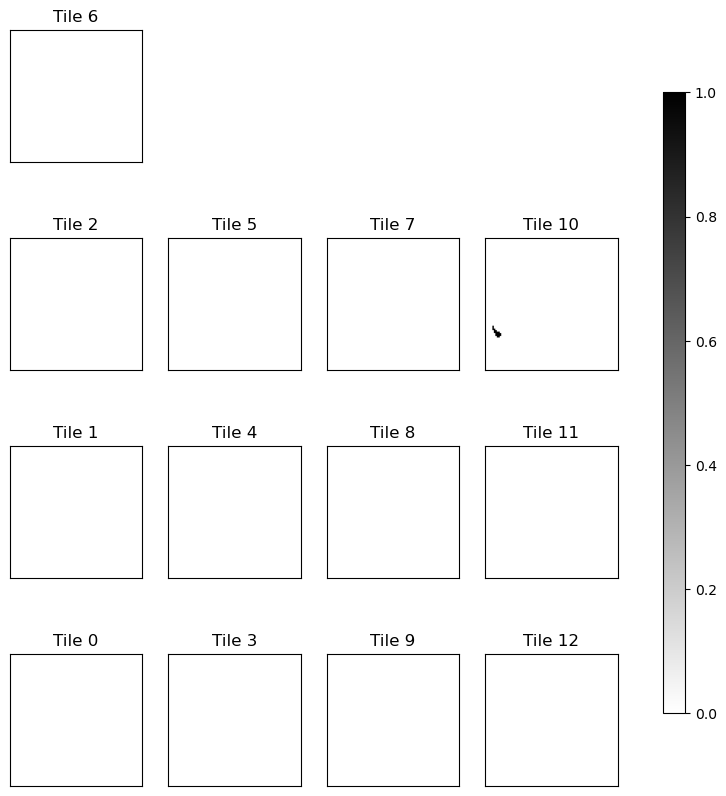

In [6]:
plt.figure(figsize=(5,5));
ecco.plot_tiles(ywu_surf_mask, show_colorbar=True, 
                cmin=0, cmax=1, 
                cmap="binary", 
                rotate_to_latlon=True, layout='latlon',
               show_tile_labels=True);

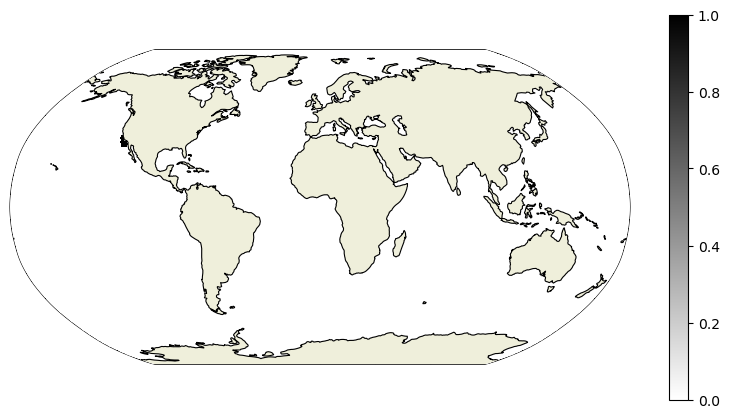

In [7]:
plt.figure(figsize=(10,5));
ecco.plot_proj_to_latlon_grid(ds_GEOM.XC, ds_GEOM.YC,\
                              ywu_surf_mask,\
                              show_colorbar=True,\
                              cmap='binary', \
                              cmin=0, cmax=1,
                              dx=1,dy=1);

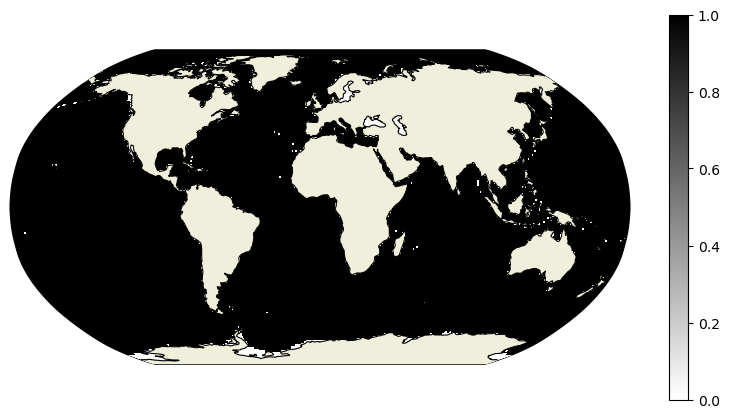

In [8]:
plt.figure(figsize=(10,5));
ecco.plot_proj_to_latlon_grid(ds_GEOM.XC, ds_GEOM.YC,\
                              get_depth_mask(ds_GEOM, 0, -200).isel(k = 0),\
                              show_colorbar=True,\
                              cmap='binary', \
                              cmin=0, cmax=1,
                              dx=1,dy=1);

In [9]:
ywu_surf_mask.max()

<xarray.DataArray 'mask_ccc_surf' ()> Size: 8B
array(1)

In [10]:
CCC_mask = (get_depth_mask(ds_GEOM, 0, -50) * ywu_surf_mask).rename("CCC_surf_mask").to_dataset()
CCC_mask["CCC_sub_surf_mask"] = get_depth_mask(ds_GEOM, -100, -210) * ywu_surf_mask
CCC_mask["CCC_column_mask"] = get_depth_mask(ds_GEOM, 0, -7000) * ywu_surf_mask

CCC_mask["sub_surf_mask"] = get_depth_mask(ds_GEOM, -100, -210) 
CCC_mask["surf_mask"] = get_depth_mask(ds_GEOM, 0, -50) 

CCC_mask = CCC_mask.compute()

In [11]:
datadir = lambda x: "/efs_ecco/ameza/ESS25-Team_SHERLOCCS/masks/" + x

CCC_mask.to_netcdf(datadir("CCC_mask.nc"))

In [12]:
CCC_mask["CCC_column_mask"].sum() #just confirming that everything is 0 or 1 

<xarray.DataArray 'CCC_column_mask' ()> Size: 8B
array(702)